<a href="https://colab.research.google.com/github/cegfdb/IRT/blob/master/Copy_of_1PL_model_in_Pyro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install pyro-ppl

     |████████████████████████████████| 614kB 5.3MB/s 


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import torch
import torch.nn as nn

import pyro
import pyro.distributions as dist
import pyro.optim as optim
import pyro.poutine as poutine
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.mcmc import MCMC, NUTS
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
import torch.distributions.constraints as constraints

pyro.enable_validation(True)

##Generate data

In [ ]:
n_persons = 1000
n_questions = 20

np.random.seed(543678)
true_theta = np.random.normal(loc=0, scale=1, size=(n_persons,1))
true_theta = np.tile(true_theta, n_questions)
true_beta = np.random.normal(loc=0, scale=1, size=(1,n_questions))

In [ ]:
true_beta.size

20

In [ ]:
likelihood = np.exp(true_theta - true_beta) / (1 + np.exp(true_theta - true_beta))
answers = np.random.binomial(size=(n_persons, n_questions), p=likelihood, n=1) # calculate answers based on theta and likelihood function
answers = torch.tensor(answers).float() # convert to tensor

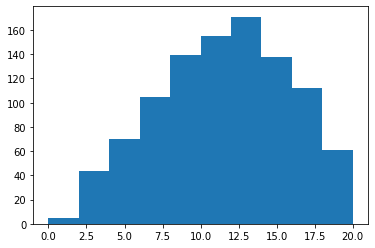

In [ ]:
plt.hist(torch.sum(answers, 1))
plt.show()

In [ ]:
# Define model
def rasch(data):
    n_persons = data.shape[0]
    n_questions = data.shape[1]
    person_plate = pyro.plate('person', n_persons, dim=-2) 
    question_plate = pyro.plate('question', n_questions, dim=-1) 

    with person_plate: # 1st dimension independent
        theta = pyro.sample(
            'theta', pyro.distributions.Normal(0, 1)) # batch_shape: (n_persons, 1) - .expand([n_persons]) is automatic
    with question_plate: # 2nd dimension independent
        beta = pyro.sample(
            'beta', pyro.distributions.Normal(0, 1)) # batch_shape: (n_questions)
    with person_plate, question_plate: 
        # Likelihood
        eta = theta - beta
        p = 1 / (1 + torch.exp(-eta))
        # Observation
        obs = pyro.sample(
            'obs', dist.Bernoulli(p), obs=data) 
    return obs, theta, beta

In [ ]:
# Print distribution shape (batch_shape | event_shape), value shape and log probability shape
trace = poutine.trace(rasch).get_trace(answers)
trace.compute_log_prob()
print(trace.format_shapes())

Trace Shapes:            
 Param Sites:            
Sample Sites:            
  person dist           |
        value      1000 |
     log_prob           |
question dist           |
        value        20 |
     log_prob           |
   theta dist 1000    1 |
        value 1000    1 |
     log_prob 1000    1 |
    beta dist        20 |
        value        20 |
     log_prob        20 |
     obs dist 1000   20 |
        value 1000   20 |
     log_prob 1000   20 |


In [ ]:
conditioned_obs, theta_prior, beta_prior = rasch(answers)
print(conditioned_obs.shape)
print(theta_prior.shape)
print(beta_prior.shape)

torch.Size([1000, 20])
torch.Size([1000, 1])
torch.Size([20])


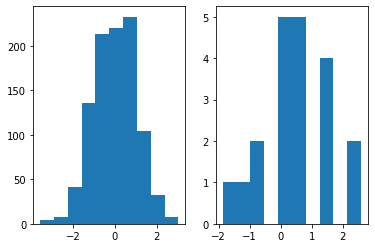

In [ ]:
plt.figure()
plt.subplot(121)
plt.hist(theta_prior.flatten())
plt.subplot(122)
plt.hist(beta_prior.flatten())
plt.show()

RMSE: 1.422760248184204


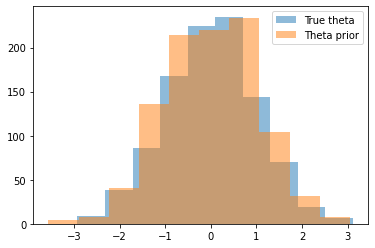

In [ ]:
# Compare prior sample of theta to true theta
plt.hist(true_theta[:, 0], alpha=0.5, label='True theta')
plt.hist(theta_prior.flatten(), alpha=0.5, label='Theta prior')
plt.legend()
print('RMSE: {}'.format(torch.sqrt(torch.mean(torch.pow(theta_prior.flatten() - torch.tensor(true_theta[:, 0]).float(), 2)))))

## Define guide

In [ ]:
# Vectorized guide - seems to have issues with parameter sizes? Posterior is not ok
def rasch_guide(data):
    n_persons = torch.tensor(data.shape[0])
    n_questions = torch.tensor(data.shape[1])
    person_plate = pyro.plate('person', n_persons, dim=-2)
    question_plate = pyro.plate('question', n_questions, dim=-1)

    theta_sigma = pyro.param('theta_sigma', torch.ones(n_persons), constraint=constraints.positive)         
    beta_sigma = pyro.param('beta_sigma', torch.ones(n_questions), constraint=constraints.positive)
  
    with person_plate: # 1st dimension independent
        theta_mu = pyro.param('theta_mu', torch.zeros(n_persons))
        theta = pyro.sample('theta', pyro.distributions.Normal(theta_mu.unsqueeze(-1), theta_sigma.unsqueeze(-1)))
        #print("guide theta",theta.shape,"theta_mu",theta_mu.shape,"theta_sigma",theta_sigma.shape)
   
    with question_plate: # 2nd dimension independent
        beta_mu = pyro.param('beta_mu', torch.zeros(n_questions))
        beta = pyro.sample('beta', pyro.distributions.Normal(beta_mu, beta_sigma))
        #print("guide beta",beta.shape)
    
    return theta, beta

In [ ]:
pyro.clear_param_store()
trace = poutine.trace(rasch_guide).get_trace(answers)
trace.compute_log_prob()
print(trace.format_shapes())

Trace Shapes:               
 Param Sites:               
  theta_sigma           1000
   beta_sigma             20
     theta_mu           1000
      beta_mu             20
Sample Sites:               
  person dist              |
        value      1000    |
     log_prob              |
question dist              |
        value        20    |
     log_prob              |
   theta dist 1000    1    |
        value 1000    1    |
     log_prob 1000    1    |
    beta dist        20    |
        value        20    |
     log_prob        20    |


In [ ]:
pyro.clear_param_store()
theta_q, beta_q = rasch_guide(answers)
print(theta_q.shape)
print(beta_q.shape)

torch.Size([1000, 1])
torch.Size([20])


## Run inference

In [ ]:
pyro.clear_param_store()
NUM_STEPS = 2500

svi = SVI(
    model=rasch, 
    guide=rasch_guide,
    #optim=optim.SGD({"lr": 0.0005, "momentum":0.1}),
    optim=optim.Adam({'lr': 0.05}),
    loss=pyro.infer.Trace_ELBO(),
   # num_samples=10, # Number of samples for Monte Carlo posterior approximation
   # num_steps= # Number of optimization steps to take in run()
)
                
losses, theta, theta_mu, theta_sigma = [], [], [], []
for t in range(NUM_STEPS):
    losses.append(svi.step(answers))
    theta_mu.append(pyro.param('theta_mu'))
    theta_sigma.append(pyro.param('theta_sigma'))
    theta_mu.append(pyro.param('auto_loc')[0].item())
    theta_sigma.append(pyro.param('auto_scale')[0].item())


KeyError: ignored

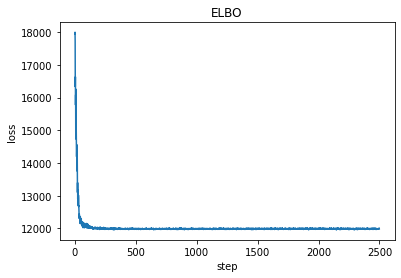

In [ ]:
plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss")
plt.show()

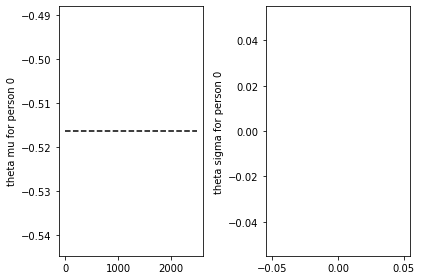

In [ ]:
plt.subplot(1,2,1)
plt.hlines(xmin=0, xmax=NUM_STEPS, y=true_theta[0,0], linestyles='--')
plt.plot(theta_mu)
plt.ylabel('theta mu for person 0')

plt.subplot(1,2,2)
plt.plot(theta_sigma)
plt.ylabel('theta sigma for person 0')
plt.tight_layout()

In [ ]:
for p in pyro.get_param_store().get_all_param_names():
    print('{}: {}'.format(p, pyro.param(p).item()))

ValueError: ignored

## Get approximated posterior

Sample from the variational distribution

In [ ]:
# Sample from the approximated posterior distribution using the parameterized guide
theta_posterior, beta_posterior = rasch_guide(answers)
print(theta_posterior.shape)
print(beta_posterior.shape)

torch.Size([1000, 1])
torch.Size([20])


RMSE: 0.6677572727203369


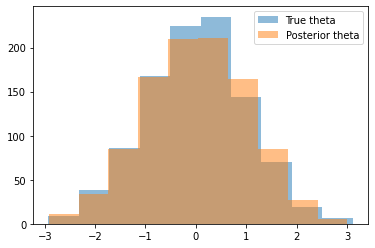

In [ ]:
# Compare posterior sample of theta to true theta
plt.hist(true_theta[:, 0], alpha=0.5, label='True theta')
plt.hist(theta_posterior[:n_persons].detach().flatten(), alpha=0.5, label='Posterior theta')
plt.legend()
print('RMSE: {}'.format(torch.sqrt(torch.mean(torch.pow(theta_posterior[:n_persons].detach().flatten() - torch.tensor(true_theta[:, 0]).float(), 2)))))

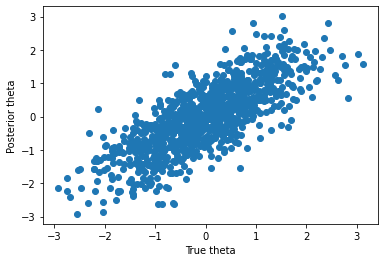

In [ ]:
# Compare posterior sample of theta to true theta
plt.scatter(true_theta[:, 0], theta_posterior[:n_persons].detach().flatten())
plt.xlabel('True theta')
plt.ylabel('Posterior theta')
plt.show()